# Model Tuning
---

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

import params as p
import functions as f

from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import r2_score

import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntUniformDistribution, UniformDistribution, LogUniformDistribution, CategoricalDistribution
from optuna.samplers import TPESampler

/opt/anaconda3/envs/data_analytics/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Settings

In [2]:
warnings.simplefilter(action='ignore', category = FutureWarning)

### Import Data

In [3]:
# Load train, test and validation datasets
train, test, val = f.load_split_datasets(part = '03')

In [4]:
# Split datasets into X and y components
X_train, y_train = f.split_data_X_y(train)
X_test, y_test = f.split_data_X_y(test)
X_val, y_val = f.split_data_X_y(val)

In [5]:
# Define train/test/validation dictionaries to make fitting and evaluation arguments cleaner
train_data = {'X' : X_train, 'y' : y_train}
test_data = {'X' : X_test, 'y' : y_test}
val_data = {'X' : X_val, 'y' : y_val}

### Create Baseline Model

In [6]:
print('lr model...', end = ' ')
lr = LinearRegression().fit(**train_data)
print('trained')

# print('xgb model...', end = ' ')
# xgb = XGBRegressor(random_state = p.RANDOM_STATE).fit(**train_data)
# print('trained')

# print('rf model...', end = ' ')
# rf = RandomForestRegressor(random_state=p.RANDOM_STATE).fit(**train_data)
# print('trained')

lr model... trained


### Evaluate Initial Models on Train and Test Data

In [7]:
models = [lr]

rmse_initial_results = {
    'Model' : ['Linear Regresssion (Baseline)'],
    'R2 Train' : [f.evaluate_model(model, metric = 'r2', **train_data) for model in models],
    'R2 Test' : [f.evaluate_model(model, metric = 'r2', **test_data) for model in models]
    }
initial_results = pd.DataFrame(rmse_initial_results)
initial_results[['R2 Train', 'R2 Test']].T

,0
R2 Train,0.567670
R2 Test,0.551524


### Initial Models for xgb/rf

In [8]:
base_params = {
    'n_jobs' : -1,
    'random_state' : p.RANDOM_STATE,
    }

In [9]:
xgb_optuna_base = XGBRegressor(**base_params)

In [10]:
rf_optuna_base = RandomForestRegressor(**base_params)

In [11]:
models = [lr, xgb_optuna_base, rf_optuna_base]

rmse_initial_results = {
    'Model' : ['Linear Regresssion (Baseline)', 'Initial XGBoost', 'Initial Random Forest'],
    'R2 Train' : [f.evaluate_model(model.fit(**train_data), metric = 'r2', **train_data) for model in models],
    'R2 Test' : [f.evaluate_model(model.fit(**train_data), metric = 'r2', **test_data) for model in models]
    }
initial_results = pd.DataFrame(rmse_initial_results)
initial_results

,Model,R2 Train,R2 Test
0,Linear Regresssion (Baseline),0.567670,0.551524
1,Initial XGBoost,0.986061,0.910505
2,Initial Random Forest,0.983250,0.883622


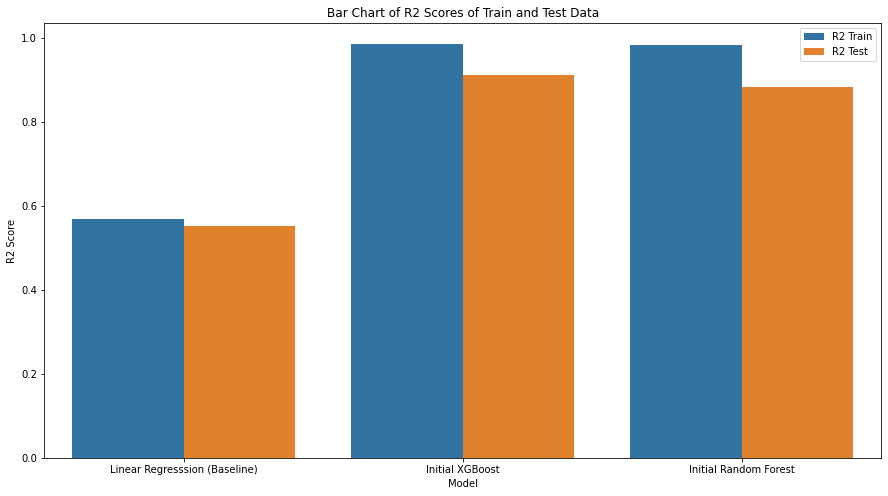

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))

melt_data = initial_results.melt(id_vars = 'Model')

sns.barplot(
    ax = ax,
    data = melt_data,
    x = 'Model',
    y = 'value',
    hue = 'variable').set(title = 'Bar Chart of R2 Scores of Train and Test Data')

plt.ylabel('R2 Score')
plt.legend()
plt.savefig(p.OUTPUTS_PATH + 'initial_models.png')
plt.show()

1. The Linear Regression model does show a reasonable performance and, since we cannot tune it, will provide a good baseline to compare our initial results against.

1. We can see that the XGBoost model does seem to have the best performance currently with R2 scores of 0.986061 and 0.910505 from train and test respectively. However, the RandomForest model does show similar R2, albeit slightly lower. Since these are the two models that are more open to extensive tuning, initial results show that the most appropriate model will be one of these. Comparing these models to our baseline, we can see that we have already got more value out changing the model before tuning.

### Model Tuning - Optuna

We will be using the optuna framework to train our models due to the improved performance on sklearn's `RandomizedSearchCV` and the nice structure optuna brings.

1. We start with the XGBoost tuning, breaking it down into three sections: Tree-based parameters, Regularization Parameters and Learning Rate. We will use a separate optuna study for each section to effectively tune the model and avoid over fitting. Tree-based parameters include `max_depth`, `min_child_weight`, `n_estimators`, `subsample`, `gamma` and `colsample_by_tree`; Regularization parameters include `alpha` and `lambda` to focus on over fitting control; and the final section just looks at finding the optimal `learning_rate` based on the other optimal parameters.

1. Since all the RandomForest parameters fall into the same category, we can use a single optuna study to tune this model. The parameters that we will be tuning are the following: `max_depth`, `max_features`, `n_estimators`, `bootstrap`, `min_samples_leaf` and `min_samples_split`.

1. The final model to tune is the Naive Bayes model which only requires tuning of `var_smoothing` which helps control over fitting.

In [13]:
sampler = TPESampler(seed = p.RANDOM_STATE)

In [14]:
def test_hyperparameter_on_model(model, param, param_values):

    base_params = {
        'n_jobs' : -1,
        'random_state' : p.RANDOM_STATE,
        }

    results_record = {'Train R2 Score' : [], 'Test R2 Score' : []}

    for pv in param_values:

        model_params = {**base_params, param : pv}


        if model == 'xgb':

            fn_model = XGBRegressor(**model_params).fit(**train_data)

        elif model == 'rf':

            fn_model = RandomForestRegressor(**model_params).fit(**train_data)

        train_r2 = f.evaluate_model(fn_model, metric = 'r2', **train_data)
        test_r2 = f.evaluate_model(fn_model, metric = 'r2', **test_data)

        results_record['Train R2 Score'].append(train_r2)
        results_record['Test R2 Score'].append(test_r2)

    fig, ax = plt.subplots(1,1,figsize = (15,8))

    sns.lineplot(ax=ax, data = pd.DataFrame(results_record), x = param_values, y = 'Train R2 Score')
    sns.lineplot(ax=ax, data = pd.DataFrame(results_record), x = param_values, y = 'Test R2 Score')

    plt.show()

### XGB Tuning

In [15]:
xgb_results_record = {
    'Models' : ['Base', 'Tuned with Optuna'],
    'Train R2 Score' :[],
    'Test R2 Score' : []
    }

In [56]:
xgb_optuna_base = XGBRegressor(**base_params, max_depth = 3, learning_rate = 0.01)

In [17]:
xgb_oscv_params = {
    'min_child_weight' : IntUniformDistribution(5, 10),
    'n_estimators' : IntUniformDistribution(50, 1000),
    'subsample' : UniformDistribution(0.1, 1),
    'gamma' : LogUniformDistribution(1e-2, 10.0),
    'colsample_bytree' : UniformDistribution(0.1, 1),
    'reg_lambda' : LogUniformDistribution(1e-2, 10.0),
    'reg_alpha' : LogUniformDistribution(1e-2, 10.0)
    }

xgb_study = optuna.create_study(sampler = sampler, direction = 'maximize', study_name = 'XGB_HyperParam_CV')

xgb_oscv = OptunaSearchCV(
    study = xgb_study,
    estimator = xgb_optuna_base,
    param_distributions = xgb_oscv_params,
    cv = 10,
    n_jobs = -1,
    n_trials = 200,
    random_state = p.RANDOM_STATE,
    refit = True,
    scoring = 'r2',
    verbose = 1,
)

xgb_oscv.fit(X_train, y_train, verbose = 0)

[I 2022-04-07 14:29:23,386] A new study created in memory with name: XGB_HyperParam_CV
/var/folders/2f/cwgmhyzx4fn5cwp5j_dpmsd00000gn/T/ipykernel_67318/3095617847.py:14: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  xgb_oscv = OptunaSearchCV(
[I 2022-04-07 14:29:23,396] Searching the best hyperparameters using 5083 samples...
[I 2022-04-07 14:30:06,992] Trial 3 finished with value: 0.5421425900176836 and parameters: {'min_child_weight': 8, 'n_estimators': 259, 'subsample': 0.3384038205943115, 'gamma': 3.926503885250751, 'colsample_bytree': 0.5483045432016561, 'reg_lambda': 0.24917781422244695, 'reg_alpha': 1.286926925179098, 'learning_rate': 1}. Best is trial 3 with value: 0.5421425900176836.
[I 2022-04-07 14:30:42,381] Trial 7 finished with value: 0.8219417689895435 and parameters: {'min_child_weight': 9, 'n_estimators': 500, 'subsample': 0.16034676547348375, 'gamma': 6.870658777039842, 'colsample_bytree': 0.172

OptunaSearchCV(cv=10,
               estimator=XGBRegressor(base_score=None, booster=None,
                                      colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      enable_categorical=False, gamma=None,
                                      gpu_id=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_delta_step=None,
                                      max_depth=3, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      n...
                                    'min_child_weight': IntUniformDistribution(high=10, low=5, step=1),
                                    'n_estimators': IntUniformDistribution(high=1000, low=50, step=1),
                           

In [18]:
def make_optuna_visualizations(study: optuna.Study): 

    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

    fig = optuna.visualization.plot_slice(study)
    fig.show()

make_optuna_visualizations(xgb_study)

In [19]:
xgb_tuned = xgb_oscv.best_estimator_

#### Optuna-Tuned XGB Model

In [20]:
model = xgb_tuned

train_r2 = f.evaluate_model(model, metric = 'r2', **train_data)
test_r2 = f.evaluate_model(model, metric = 'r2', **test_data)

xgb_results_record['Train R2 Score'].append(train_r2)
xgb_results_record['Test R2 Score'].append(test_r2)

print('Train R2:', train_r2)
print('Test R2:', test_r2)

Train R2: 0.946409
Test R2: 0.89225


### Parameter Adjustments - Based on importance plot

In [57]:
# test_params = xgb_oscv.best_params_
# test_params['learning_rate'] = 0.01
# test_params['max_depth'] = 3
test_m = xgb_optuna_base.fit(**train_data)
print(f.evaluate_model(test_m, metric = 'r2', **train_data))
print(f.evaluate_model(test_m, metric = 'r2', **test_data))

0.427923
0.409139


### RandomForest Model Tuning

As mentioned, since the RandomForest hyperparameters are tree-based, we can tune them all with a single study. The parameters we will be tuning are the following: `max_depth`, `max_features`, `n_estimators`, `bootstrap`, `min_samples_leaf` and `min_samples_split`.

In [21]:
model = rf_optuna_base.fit(**train_data)

train_r2 = f.evaluate_model(model, metric = 'r2', **train_data)
test_r2 = f.evaluate_model(model, metric = 'r2', **test_data)

xgb_results_record['Train R2 Score'].append(train_r2)
xgb_results_record['Test R2 Score'].append(test_r2)

print('Train R2:', train_r2)
print('Test R2:', test_r2)

Train R2: 0.98325
Test R2: 0.883622


In [22]:
rf_oscv_params = {
    'max_depth' : IntUniformDistribution(6, 15),
    'max_features' : CategoricalDistribution(['auto', 'sqrt', 'log2']),
    'n_estimators' : IntUniformDistribution(50, 1000),
    'bootstrap' : CategoricalDistribution([True, False]),
    'min_samples_leaf' : UniformDistribution(0, 0.5),
    'min_samples_split' : UniformDistribution(0, 0.5),
    }

rf_study = optuna.create_study(sampler = sampler, direction = 'maximize', study_name = 'RF_HyperParam_CV')

rf_oscv = OptunaSearchCV(
    study = rf_study,
    estimator = rf_optuna_base,
    param_distributions = rf_oscv_params,
    cv = 10,
    n_jobs = -1,
    n_trials = 200,
    random_state = p.RANDOM_STATE,
    refit = True,
    scoring = 'r2',
    verbose = 1
)

rf_oscv.fit(X_train, y_train)

[I 2022-04-07 15:54:58,463] A new study created in memory with name: RF_HyperParam_CV
/var/folders/2f/cwgmhyzx4fn5cwp5j_dpmsd00000gn/T/ipykernel_67318/548707989.py:12: ExperimentalWarning:

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.

[I 2022-04-07 15:54:58,469] Searching the best hyperparameters using 5083 samples...
[I 2022-04-07 15:55:29,489] Trial 6 finished with value: 0.13681908824762234 and parameters: {'max_depth': 8, 'max_features': 'log2', 'n_estimators': 276, 'bootstrap': False, 'min_samples_leaf': 0.44375912202875684, 'min_samples_split': 0.024750205717561924}. Best is trial 6 with value: 0.13681908824762234.
[I 2022-04-07 15:55:35,066] Trial 5 finished with value: 0.16194840218469625 and parameters: {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 346, 'bootstrap': True, 'min_samples_leaf': 0.2626674826548199, 'min_samples_split': 0.4067807161915308}. Best is trial 5 with value: 0.16194840218469625.
[I 2022-04-0

OptunaSearchCV(cv=10,
               estimator=RandomForestRegressor(n_jobs=-1, random_state=73),
               n_jobs=-1, n_trials=200,
               param_distributions={'bootstrap': CategoricalDistribution(choices=(True, False)),
                                    'max_depth': IntUniformDistribution(high=15, low=6, step=1),
                                    'max_features': CategoricalDistribution(choices=('auto', 'sqrt', 'log2')),
                                    'min_samples_leaf': UniformDistribution(high=0.5, low=0.0),
                                    'min_samples_split': UniformDistribution(high=0.5, low=0.0),
                                    'n_estimators': IntUniformDistribution(high=1000, low=50, step=1)},
               random_state=73, scoring='r2',
               study=<optuna.study.study.Study object at 0x174a39250>,
               verbose=1)

In [23]:
make_optuna_visualizations(rf_study)

In [24]:
rf_tuned = rf_oscv.best_estimator_

In [25]:
print('Train R2:', f.evaluate_model(rf_tuned, metric = 'r2', **train_data))
print('Test R2:', f.evaluate_model(rf_tuned, metric = 'r2', **test_data))

Train R2: 0.871445
Test R2: 0.828518


R2 scores of 0.797747 and 0.756056 on our train and test data respectively. This is a substantial change to our initial RandomForest model; however, we have eliminated the massive over fitting that was being performed at the initial modelling stage. We will look at how our model performs on our validation data and compare it to other models.

### Evaluate Final, Tuned Models on validation data

In [26]:
tuned_models = [lr, xgb_tuned, rf_tuned]

tuned_rmse = {
    'R2 Train' : [f.evaluate_model(model, metric = 'r2', **train_data) for model in tuned_models],
    'R2 Test' : [f.evaluate_model(model, metric = 'r2', **test_data) for model in tuned_models],
    'R2 Validation' : [f.evaluate_model(model, metric = 'r2', **val_data) for model in tuned_models]
    }
    
pd_rmse = pd.DataFrame(tuned_rmse, index = ['Linear Regression', 'Tuned XGBoost', 'Tuned RandomForest'])
pd_rmse

,R2 Train,R2 Test,R2 Validation
Linear Regression,0.567670,0.551524,0.537439
Tuned XGBoost,0.946409,0.892250,0.887849
Tuned RandomForest,0.871445,0.828518,0.837286


Looking at these R2 scores, it looks like the Tuned XGBoost model is the appropriate model for this problem due to it having the highest validation R2 score, close train and test R2 scores suggesting minimal over fitting, and high R2 scores in general for each dataset.

#### Make Plot to show Residuals for each model

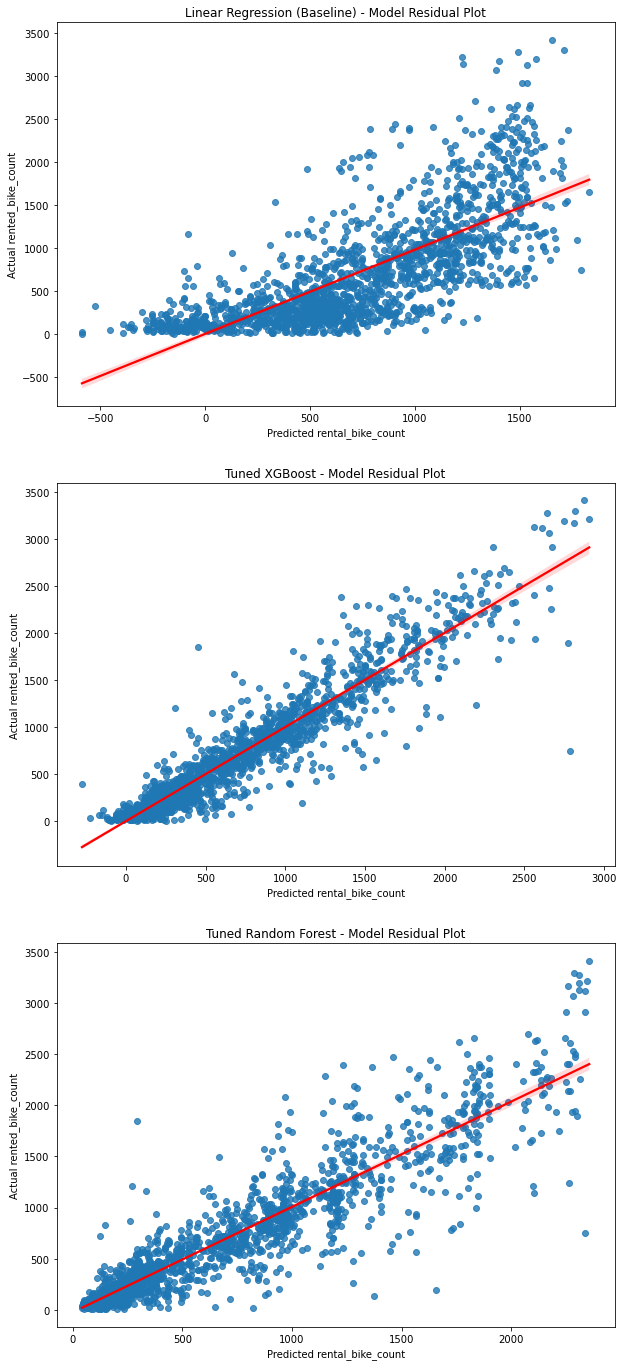

In [27]:
def make_residual_plot():

    fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize=(10, 24))

    for idx, model_info in enumerate([('Linear Regression (Baseline)', lr), ('Tuned XGBoost', xgb_tuned), ('Tuned Random Forest', rf_tuned)]):

        model_name = model_info[0]
        model = model_info[1]

        sns.regplot(
            ax = ax[idx],
            x = model.predict(X_val),
            y = y_val,
            line_kws = {'color' : 'r'},
        ).set(title = f'{model_name} - Model Residual Plot', ylabel = 'Actual rented_bike_count', xlabel = 'Predicted rental_bike_count')

    plt.savefig(p.OUTPUTS_PATH + 'residuals1.png')
    plt.show()

make_residual_plot()

As we can from the residual plots above, the Tuned XGBoost model has residuals closest to the y = 0 line. It looks like the residuals are larger at the extremities.... unexplained variance.

### Plot Histogram of Results

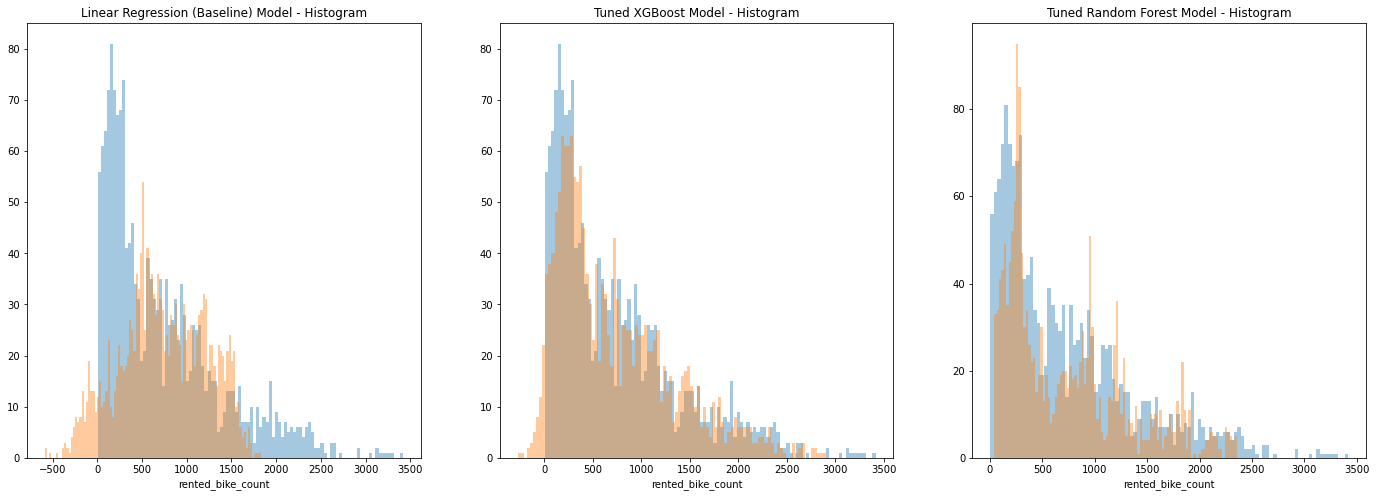

In [28]:
def display_dual_histograms():

    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (24, 8))

    for idx, model_info in enumerate([('Linear Regression (Baseline)', lr), ('Tuned XGBoost', xgb_tuned), ('Tuned Random Forest', rf_tuned)]):

        model_name = model_info[0]
        model = model_info[1]

        for x in [y_val, model.predict(X_val)]:
            sns.distplot(x, bins = 100, ax=ax[idx], kde = False).set(title = f'{model_name} Model - Histogram')

    plt.show()

display_dual_histograms()

### Save the best model

In [29]:
f.save_model_and_preds(xgb_tuned, model_name = 'best', X = X_val)